In [1]:
%matplotlib inline
from sklearn.cross_validation import KFold
from sklearn.metrics import roc_curve, roc_auc_score

/Applications/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
data87=pd.read_csv('/Users/wsswemily/Desktop/GOM/Amazon/machadinho_data_1987.csv')
data87=data87.iloc[:803,6:58]
names=data87.columns.values

(array([ 138.,   66.,   90.,   63.,  104.,   89.,   79.,   85.,   47.,   42.]),
 array([-2.30258509, -2.06279557, -1.82300604, -1.58321651, -1.34342698,
        -1.10363746, -0.86384793, -0.6240584 , -0.38426887, -0.14447935,
         0.09531018]),
 <a list of 10 Patch objects>)

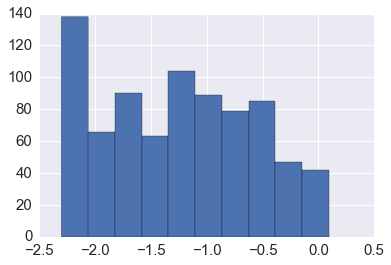

In [3]:
data87=np.array(np.transpose(data87))
data87[0]=np.log(data87[0].astype('float')+0.1)
plt.hist(data87[0])

In [4]:
#turn rate into 0 or 1
for i in range(data87.shape[1]):
    if data87[0][i]<-2.06279557:
        data87[0][i]=0
    else:
        data87[0][i]=1

In [5]:
data87=data87.astype('float')

In [8]:
def MELD_Backward_features(data, Numfolds, features, NumProf):
    """This function performs supervised MELD and backward elimination algorithm
    Parameters:
        Input: a dataframe and number of folds
        output: select maximum AUC and corresponding features 
        for every specific number of features  
    """
    #divide data into kf cross validation folds
    kf=KFold(data.shape[1],Numfolds,shuffle=False,random_state=111)
    
    def profile_class(data,phi):
        """This function calculates the GoM scores for each individual
        Parameters:
        Input: data and phi calculate from MELD
           Output: GoM score
        """
        score=np.zeros([data.shape[1],NumProf])
        profile=np.zeros([int(data.shape[0]),int(data.shape[1])])
        for j in range(data.shape[1]):
            for i in range(data.shape[0]):
                yij=int(data[i,j])
                #calculate M_ij
                profile[i,j]=np.argmax(phi[i][:,yij])
                if profile[i,j]==0:
                    score[j,0]=score[j,0]+1
                else:
                    score[j,1]=score[j,1]+1
            score[j,:]=(score[j,:]+0.1)/(phi.shape[0]+0.1*NumProf)
        return score
    
    #create a list of features
    vec_list=[]
    for j in range(len(features)-1):
        integers=features[:]
        del integers[j+1]
        vec_list.append(integers)
    
    auc_list_outer=[]
    whole_gom_list=[]
    for j in range(len(vec_list)):
        auc_list=[]
        gom_list=[]
        vec=vec_list[j]
        for i in range(Numfolds):
            train=data[:,list(kf)[i][0]]
            test=data[:,list(kf)[i][1]]
            import MELD_87 as MELD
            k=NumProf
            S=100
            Y = train
            (p,n) = Y.shape
            Yt = np.array([0]*p)
            Yt[0]=0
            # create an object of MELD class
            myMELD = MELD.MELD(Y,Yt,k,vec)
            # calculate second moment matrices
            myMELD.calM2()
            myMELD.calM2_bar()
            # ------------- first stage
            # initialize weight matrices to identity
            myMELD.initializeWeight_M2()
            # perform first stage estimation
            Result1 = myMELD.estimatePhiGrad_M2(S)
            # extract phi from the result
            phi1=Result1['PHI'][Result1['iter']]
            # extract selected features in the test fold
            test=test[vec]
            # calculate GoM score
            gscore=profile_class(test[1:],phi1[1:])
            # calculate risk
            risk=gscore[:,None]*np.transpose(phi1[0])
            risk=np.sum(risk[:,1,:],axis=1)
            gom_list.append(gscore[:,1])
            # replace 0 with label "-1"
            np.place(test[0],test[0]==0,[-1])
            # calculate AUC
            auc = roc_auc_score(test[0],risk)
            auc_list.append(auc)
        #calculate the mean AUC across kf folds
        auc_new=np.mean(auc_list)
        auc_list_outer.append(auc_new)
        whole_gom_list.append(list(np.concatenate(gom_list)))
        
    auc_all=[]
    vec_all=[]
    gom_all=[]
    while len(vec_list)>2:
        vec_list_2=vec_list[np.argmax(auc_list_outer).astype(int)] 
        gom_list_2=whole_gom_list[np.argmax(auc_list_outer).astype(int)]
        vec_all.append(vec_list_2)
        gom_all.append(gom_list_2)
        vec_list=[]
        whole_gom_list=[]
        #eliminate one feature at a time
        for k in range(len(vec_list_2)-1):
            integers=vec_list_2[:]
            del integers[k+1]
            vec_list.append(integers)

        auc_list_outer=[] 
       
        for j in range(len(vec_list)):
            auc_list=[]
            gom_list=[]
            vec=vec_list[j]

            for i in range(10):
            
                train=data[:,list(kf)[i][0]]
    
                test=data[:,list(kf)[i][1]]
        
                import MELD_87 as MELD
                k=NumProf
                S=100

                Y = train
                (p,n) = Y.shape

                Yt = np.array([0]*p)
                Yt[0]=0
                # create an object of MELD class
                myMELD = MELD.MELD(Y,Yt,k,vec)

                # calculate second moment matrices
                myMELD.calM2()
                myMELD.calM2_bar()

                # ------------- first stage
                # initialize weight matrices to identity
                myMELD.initializeWeight_M2()

                # perform first stage estimation
                Result1 = myMELD.estimatePhiGrad_M2(S)
                # extract phi from the result
                phi1=Result1['PHI'][Result1['iter']]
                # extract selected features from test fold
                test=test[vec]
                # calculate GoM score
                gscore=profile_class(test[1:],phi1[1:])
                # calculate risk
                risk=gscore[:,None]*np.transpose(phi1[0])
                risk=np.sum(risk[:,1,:],axis=1)
                gom_list.append(gscore[:,1])
                # replace 0 with label "-1"
                np.place(test[0],test[0]==0,[-1])
                # calculate AUC
                auc = roc_auc_score(test[0],risk)
                auc_list.append(auc)
            # calculate average AUC across kf folds
            auc_new=np.mean(auc_list)     
            auc_list_outer.append(auc_new)
            whole_gom_list.append(list(np.concatenate(gom_list)))
              
        
        # selected the maximum AUC from a list of AUC's
        auc_new_new=max(auc_list_outer)
    
        auc_all.append(auc_new_new)
        
        auc=np.max(auc_all)
        
        feature_selected=vec_all[np.argmax(auc_all)]
        
        gom=gom_all[np.argmax(auc_all)]
    
    return auc, feature_selected, gom

In [8]:
out_3=MELD_Backward_features(data87, 10, list(range(data87.shape[0])), 3)

/Users/wsswemily/Desktop/SMELD/MELD_87.py:75: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  Y_j = np.zeros((n,self.d[j]))
/Users/wsswemily/Desktop/SMELD/MELD_87.py:77: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  Y_j[i,Y[j,i]] = 1
/Users/wsswemily/Desktop/SMELD/MELD_87.py:79: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.Phi[j] = np.zeros((k,self.d[j]))
/Users/wsswemily/Desktop/SMELD/MELD_87.py:80: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.X[j] = np.zeros((k,self.d[j]))
/Users/wsswemily/Desktop/SMELD/MELD_87.py:87: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.Phi[j][h,:] = np.random.dirichlet([100.0]*self.d[j])
/Users/wss

KeyboardInterrupt: 

In [9]:
out_4=MELD_Backward_features(data87, 10, list(range(data87.shape[0])), 4)

/Users/wsswemily/Desktop/SMELD/MELD_87.py:75: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  Y_j = np.zeros((n,self.d[j]))
/Users/wsswemily/Desktop/SMELD/MELD_87.py:77: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  Y_j[i,Y[j,i]] = 1
/Users/wsswemily/Desktop/SMELD/MELD_87.py:79: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.Phi[j] = np.zeros((k,self.d[j]))
/Users/wsswemily/Desktop/SMELD/MELD_87.py:80: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.X[j] = np.zeros((k,self.d[j]))
/Users/wsswemily/Desktop/SMELD/MELD_87.py:87: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.Phi[j][h,:] = np.random.dirichlet([100.0]*self.d[j])
/Users/wss

In [8]:
out_5=MELD_Backward_features(data87, 10, list(range(data87.shape[0])), 5)

/Users/wsswemily/Desktop/SMELD/MELD_87.py:75: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  Y_j = np.zeros((n,self.d[j]))
/Users/wsswemily/Desktop/SMELD/MELD_87.py:77: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  Y_j[i,Y[j,i]] = 1
/Users/wsswemily/Desktop/SMELD/MELD_87.py:79: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.Phi[j] = np.zeros((k,self.d[j]))
/Users/wsswemily/Desktop/SMELD/MELD_87.py:80: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.X[j] = np.zeros((k,self.d[j]))
/Users/wsswemily/Desktop/SMELD/MELD_87.py:87: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.Phi[j][h,:] = np.random.dirichlet([100.0]*self.d[j])
/Users/wss

In [12]:
out_3[0]

0.66537034210401302

In [13]:
names[out_3[1]]

array(['rate', 'arrival', 'chainsaw', 'Hhedu', 'dirtwater', 'bednet',
       'protclot', 'insecticide', 'daysout', 'roof', 'getwater', 'bath',
       'topography', 'dforest', 'planstay', 'workedrural+1y', 'arrivRO',
       'build', 'chickenpork', 'dcurral', 'rubber', 'v601', 'v602'], dtype=object)

In [10]:
out_4[0]

0.67511291701038623

In [11]:
out_4[1]

[0, 13, 15, 17, 19, 41, 42, 51]

In [12]:
out_4[2]

[0.55405405405405395,
 0.28378378378378377,
 0.28378378378378377,
 0.28378378378378377,
 0.14864864864864866,
 0.55405405405405395,
 0.28378378378378377,
 0.28378378378378377,
 0.28378378378378377,
 0.28378378378378377,
 0.28378378378378377,
 0.28378378378378377,
 0.28378378378378377,
 0.28378378378378377,
 0.28378378378378377,
 0.41891891891891891,
 0.013513513513513514,
 0.28378378378378377,
 0.14864864864864866,
 0.41891891891891891,
 0.28378378378378377,
 0.28378378378378377,
 0.28378378378378377,
 0.41891891891891891,
 0.28378378378378377,
 0.28378378378378377,
 0.55405405405405395,
 0.28378378378378377,
 0.14864864864864866,
 0.28378378378378377,
 0.14864864864864866,
 0.14864864864864866,
 0.14864864864864866,
 0.41891891891891891,
 0.41891891891891891,
 0.28378378378378377,
 0.28378378378378377,
 0.28378378378378377,
 0.28378378378378377,
 0.28378378378378377,
 0.28378378378378377,
 0.14864864864864866,
 0.14864864864864866,
 0.14864864864864866,
 0.28378378378378377,
 0.013513

In [11]:
out_5[0]

0.69418239662671888

In [12]:
out_5[1]

[0,
 1,
 3,
 5,
 8,
 9,
 10,
 11,
 13,
 14,
 16,
 17,
 23,
 30,
 31,
 34,
 35,
 36,
 37,
 38,
 41,
 42,
 43,
 45,
 50]